In [14]:
from tensorflow.keras.datasets import mnist
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import importlib
import helper
importlib.reload(helper)

sns.set_theme()
(x_train, y_labels) , (x_test, y_test) = mnist.load_data()
train_morpho = pd.read_csv("./Data/train-morpho.csv")
test_morpho = pd.read_csv("./Data/t10k-morpho.csv")
train_morpho.drop(["index"], axis=1, inplace=True)
test_morpho.drop(["index"], axis=1, inplace=True)
train_morpho.slant = train_morpho.slant*180/np.pi
test_morpho.slant = test_morpho.slant*180/np.pi

x_val = x_train[50000:]/255
y_val = train_morpho.slant.to_numpy()[50000:] 
x_train = x_train[:50000]/255
y_train = train_morpho.slant.to_numpy()[:50000]
x_emb = y_labels[:50000]
x_emb_val = y_labels[50000:]
labels = np.unique(y_labels)

normHeight = ((train_morpho.height-train_morpho.height.mean())/train_morpho.height.std())
var_x_train = normHeight.to_numpy()[:50000]
var_x_val = normHeight.to_numpy()[50000:]
normHeight = ((test_morpho.height-test_morpho.height.mean())/test_morpho.height.std())
var_x_test = normHeight.to_numpy()

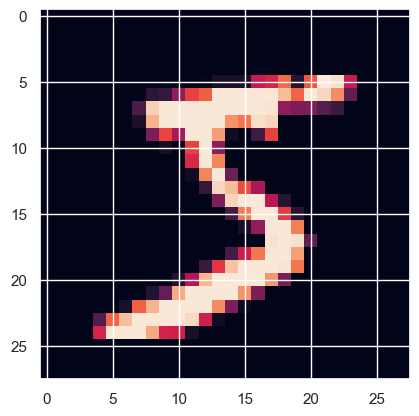

In [16]:
plt.imshow(x_train[0])

[5923 6742 5958 6131 5842 5421 5918 6265 5851 5949]


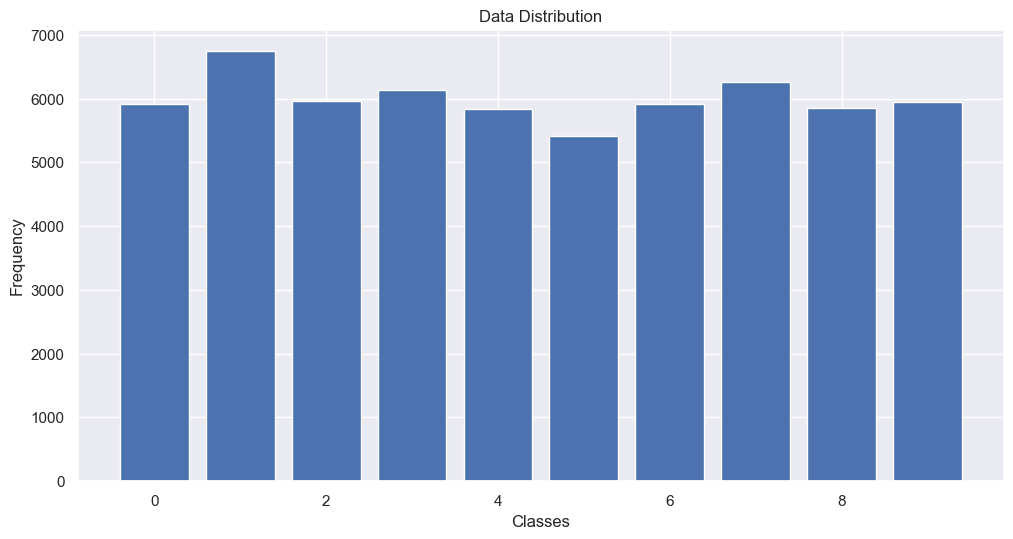

In [119]:
num, frequency = np.unique(y_labels, return_counts=True)
plt.bar(labels, frequency)
plt.gcf().tight_layout(pad=0)
plt.gcf().set_figwidth(10)
plt.xlabel("Classes")
plt.ylabel("Frequency")
plt.title("Data Distribution")

<AxesSubplot:>

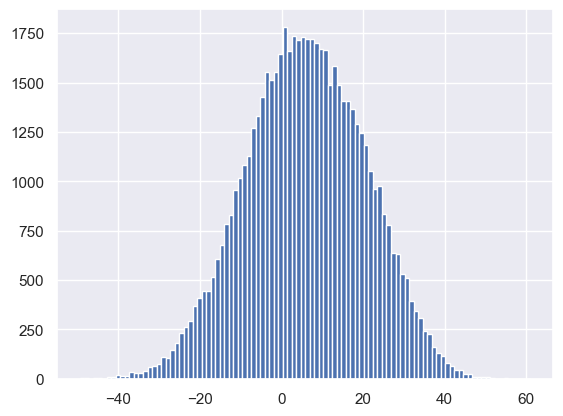

In [18]:
train_morpho.slant.hist(bins=100)

In [19]:
train_morpho.iloc[y_labels==1]

,area,length,thickness,slant,width,height
3,67.3125,22.849242,2.919769,29.174163,5.358179,19.724599
6,69.3750,19.838835,3.457017,-8.889683,5.026869,19.711565
8,41.8125,20.363961,2.190367,-4.378080,3.772309,19.458175
14,44.1250,21.692388,2.216605,-3.072578,3.974149,19.538955
23,64.6875,22.245689,2.854460,30.190546,5.230590,19.475603
...,...,...,...,...,...,...
59958,47.7500,22.977922,2.160946,23.981700,4.160436,19.564109
59965,63.9375,24.341883,2.577189,37.785202,5.596039,19.560789
59979,48.6250,23.952796,2.155981,28.702996,4.343587,19.500440
59984,59.5625,25.609650,2.378904,37.924730,5.011157,19.546802


# $\textit{Slant vs Morphos}$

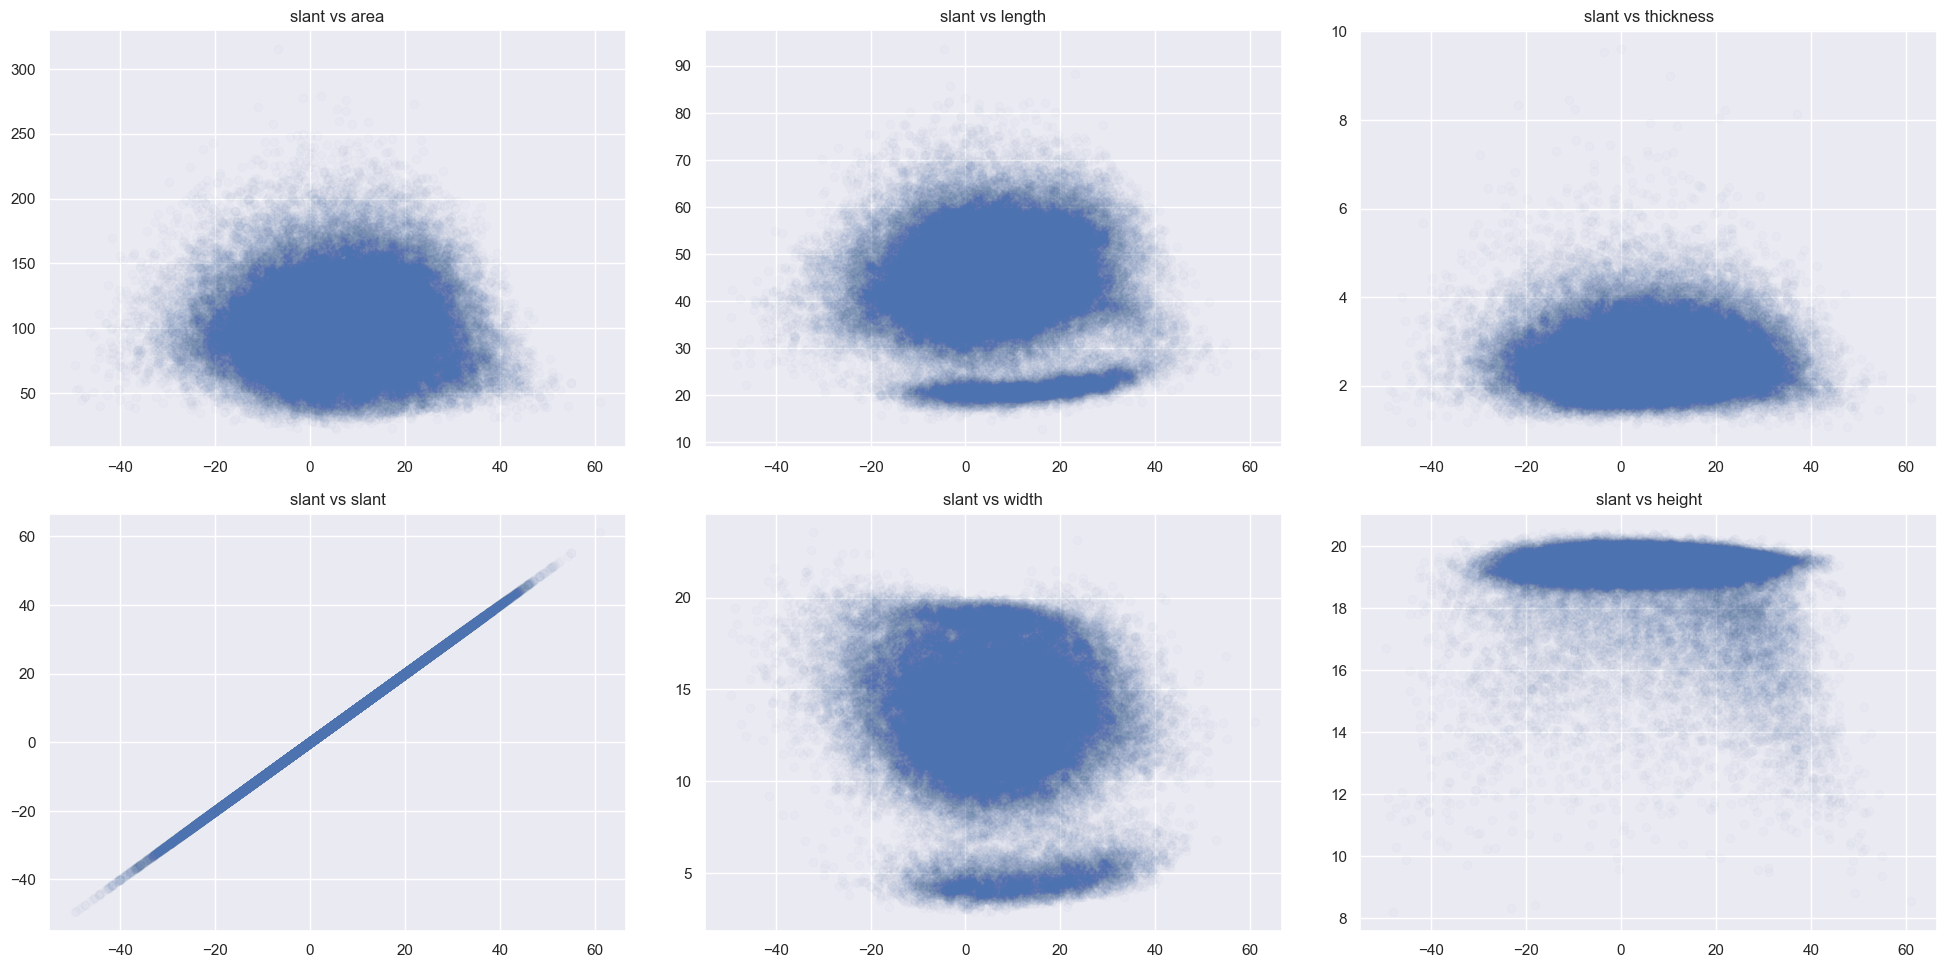

In [20]:
fig, axs = plt.subplots(2,3,figsize=(20,10))
fig.tight_layout(pad=2)

for i in range(2):
    for j in range(3):
        morph = train_morpho.columns[3*i+j]
        axs[i][j].set_title(f"slant vs {morph}")
        axs[i][j].scatter(train_morpho.slant, train_morpho[morph], alpha=0.02)

$\textit{Se observa una correlacion entre slant vs height y una menor vs thickness}$

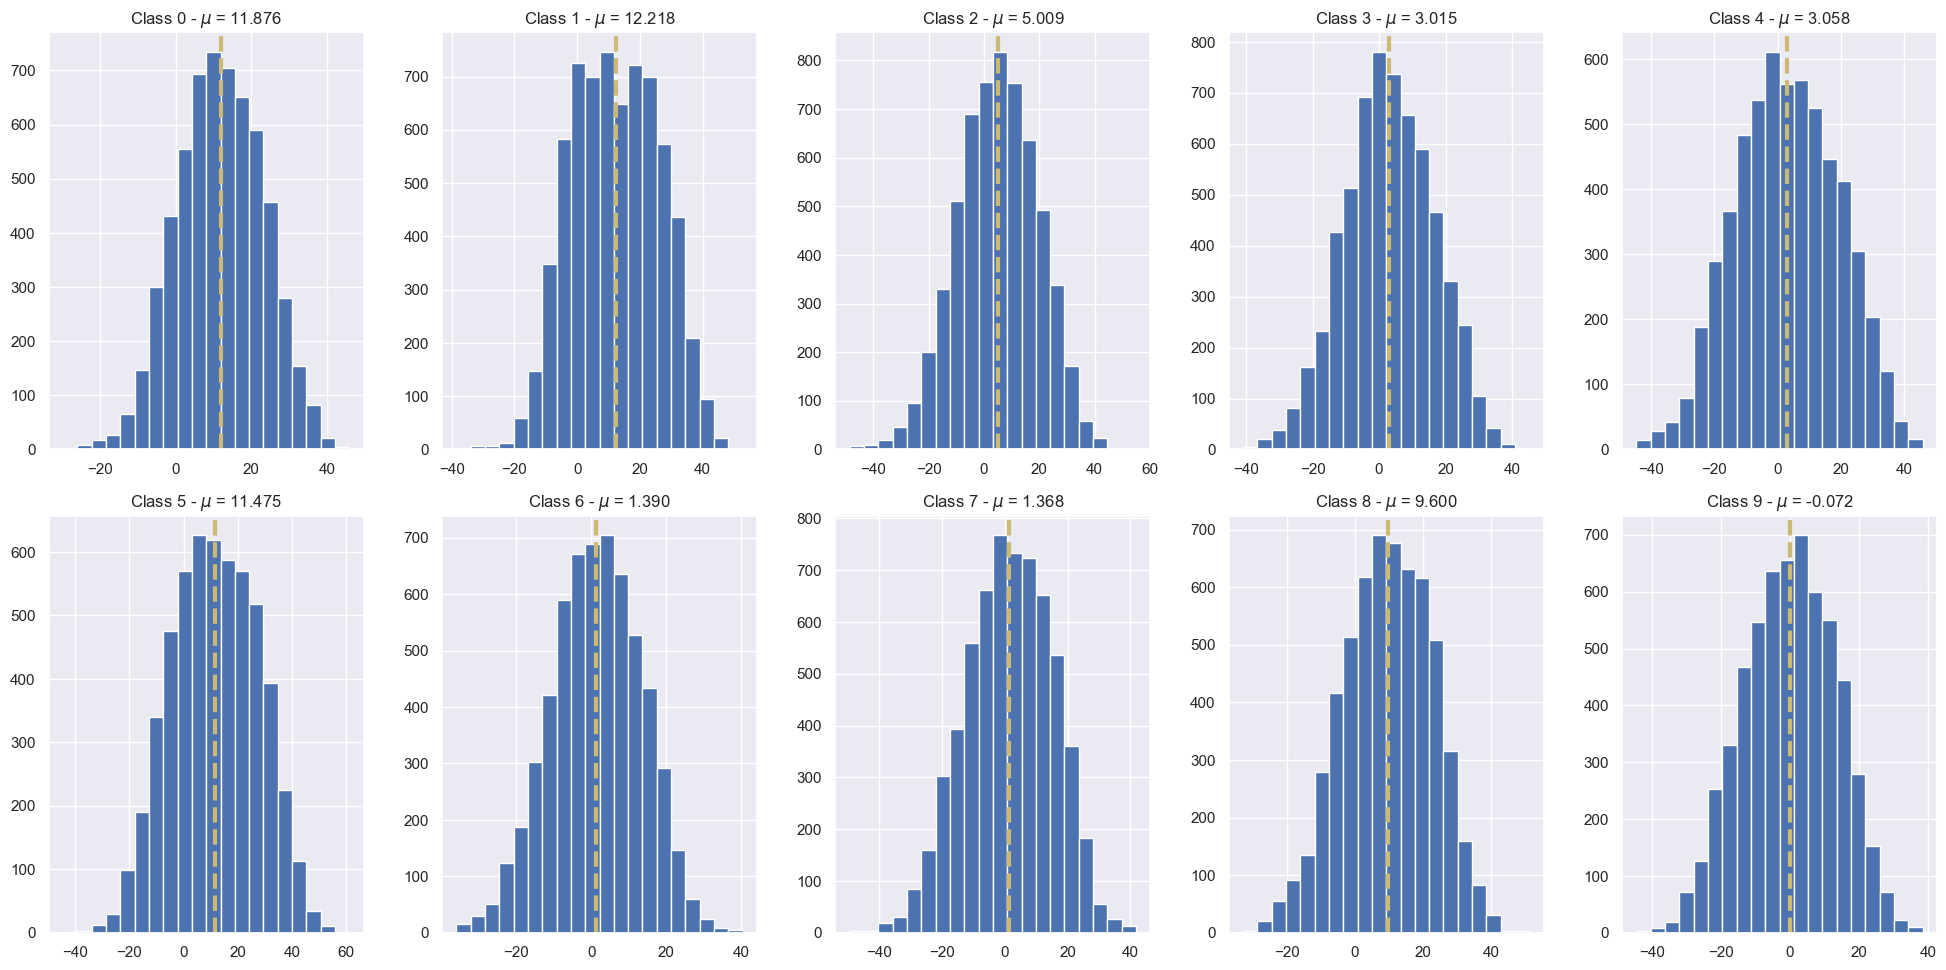

In [21]:
fig, axs = plt.subplots(2,5,figsize=(20,10))
fig.tight_layout(pad=2)

for i in range(2):
    for j in range(5):
        mu = train_morpho.iloc[y_labels==i*5+j].slant.mean()
        axs[i][j].set_title(f"Class {i*5+j} - $\mu$ = {mu:.3f}")
        axs[i][j].hist(train_morpho.iloc[y_labels==i*5+j].slant, bins=20)
        axs[i][j].axvline(mu, color='y', linestyle='dashed', linewidth=3)

In [2]:
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.initializers import GlorotNormal
from tensorflow.keras.losses import MeanAbsoluteError
import tensorflow_addons as tfa
import tensorflow as tf
import importlib as imp
import helper
imp.reload(helper)

c:\Users\Gonzalo\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


<module 'helper' from 'c:\\Users\\Gonzalo\\Documents\\Informatica\\EclipseWorkspacePython\\TP1_RN\\MorphometricMNIST\\helper.py'>

## $\textit{Predict using image only}$

In [23]:
BATCH_SIZE = 64
INIT_LR = 0.000005
MAX_LR = 0.001
steps_per_epoch = len(x_train) // BATCH_SIZE
callbackCLR = tfa.optimizers.CyclicalLearningRate(initial_learning_rate=INIT_LR,
    maximal_learning_rate=MAX_LR,
    scale_fn=lambda x: 1/(2.**(x-1)),
    step_size=2 * steps_per_epoch
)

loc = './Model/MorphometricMNISTBase/training_history.log'
callbackH = helper.callbackH(location=loc)

callbackROP = ReduceLROnPlateau(monitor="val_mae",
                      factor = 0.1,
                      verbose= 1,
                      pacience = 10,
                      max_lr = MAX_LR)

callbackES = EarlyStopping(monitor="val_mae", patience=20)
initializer = GlorotNormal()
model = Sequential()
model.add(Flatten(input_shape=(28,28)))
model.add(Dense(100, activation="sigmoid", kernel_initializer=initializer))
model.add(Dense(100, activation="sigmoid", kernel_initializer=initializer))
model.add(Dense(1, activation="linear", kernel_initializer=initializer))
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_8 (Flatten)         (None, 784)               0         
                                                                 
 dense_21 (Dense)            (None, 100)               78500     
                                                                 
 dense_22 (Dense)            (None, 100)               10100     
                                                                 
 dense_23 (Dense)            (None, 1)                 101       
                                                                 
Total params: 88,701
Trainable params: 88,701
Non-trainable params: 0
_________________________________________________________________


c:\Users\Gonzalo\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\initializers\initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [24]:
model.compile(loss = MeanAbsoluteError(), optimizer=Nadam(callbackCLR), metrics=["mae"])
history = model.fit(x=x_train, y =y_train, validation_data=(x_val, y_val), callbacks=[callbackES, callbackROP, callbackH], batch_size = BATCH_SIZE, epochs=200)
model.save("./Model/MorphometricMNISTBase")

Epoch 1/200
782/782 [==============================] - 3s 3ms/step - loss: 9.1237 - mae: 9.1237 - val_loss: 3.5370 - val_mae: 3.5370 - lr: 5.0250e-04
Epoch 2/200
782/782 [==============================] - 2s 3ms/step - loss: 1.7021 - mae: 1.7021 - val_loss: 0.7941 - val_mae: 0.7941 - lr: 9.9936e-04
Epoch 3/200
782/782 [==============================] - 2s 2ms/step - loss: 0.4751 - mae: 0.4751 - val_loss: 0.3135 - val_mae: 0.3135 - lr: 5.0123e-04
Epoch 4/200
782/782 [==============================] - 2s 2ms/step - loss: 0.3170 - mae: 0.3170 - val_loss: 0.2622 - val_mae: 0.2622 - lr: 5.9555e-06
Epoch 5/200
782/782 [==============================] - 2s 3ms/step - loss: 0.2877 - mae: 0.2877 - val_loss: 0.2643 - val_mae: 0.2643 - lr: 2.5502e-04
Epoch 6/200
782/782 [==============================] - 2s 3ms/step - loss: 0.2639 - mae: 0.2639 - val_loss: 0.2325 - val_mae: 0.2325 - lr: 5.0091e-04
Epoch 7/200
782/782 [==============================] - 2s 3ms/step - loss: 0.2282 - mae: 0.2282 - va

INFO:tensorflow:Assets written to: ./Model/MorphometricMNISTBase\assets


INFO:tensorflow:Assets written to: ./Model/MorphometricMNISTBase\assets


c:\Users\Gonzalo\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\initializers\initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


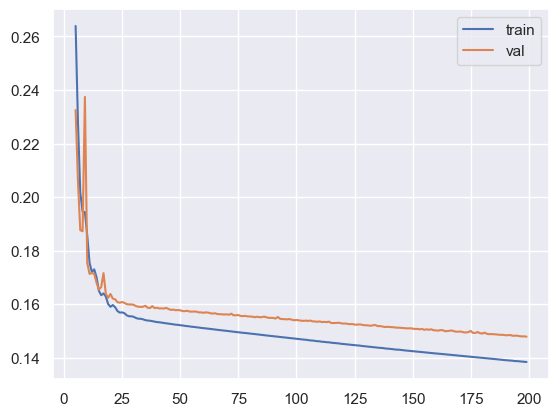

In [25]:
mode = load_model("./Model/MorphometricMNISTBase", compile=False)
histo = pd.read_csv("./Model/MorphometricMNISTBase/training_history.log")
plt.plot(histo["mae"][5:], label="train")
plt.plot(histo["val_mae"][5:], label="val")
plt.legend()
plt.show()

In [26]:
from sklearn.metrics import mean_absolute_error
model = load_model("./Model/MorphometricMNISTBase", compile=False)
predicted = model.predict(x_test).reshape(10000,)
df = pd.DataFrame()
df["pred"] = predicted
df["target"] = test_morpho.slant
df

c:\Users\Gonzalo\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\initializers\initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


313/313 [==============================] - 0s 1ms/step


,pred,target
0,3.907980,4.066199
1,-9.856485,-9.962917
2,17.420246,16.638250
3,4.734808,4.146705
4,-7.324410,-7.378214
...,...,...
9995,-2.030176,-1.446727
9996,-4.545575,-4.309251
9997,10.781695,11.246739
9998,28.220531,30.389567


## $\textit{Predict using image and label}$

In [3]:
from keras.layers import Embedding, Concatenate, Input
from keras import Model

In [28]:
BATCH_SIZE = 64
INIT_LR = 0.000005
MAX_LR = 0.001
steps_per_epoch = len(x_train) // BATCH_SIZE
callbackCLR = tfa.optimizers.CyclicalLearningRate(initial_learning_rate=INIT_LR,
    maximal_learning_rate=MAX_LR,
    scale_fn=lambda x: 1/(2.**(x-1)),
    step_size=2 * steps_per_epoch
)

loc = './Model/MorphometricMNISTEmbedding1/training_history.log'
callbackH = helper.callbackH(location=loc)

callbackROP = ReduceLROnPlateau(monitor="val_mae",
                      factor = 0.1,
                      verbose= 1,
                      pacience = 10,
                      max_lr = MAX_LR)

callbackES = EarlyStopping(monitor="val_mae", patience=20)
initializer = GlorotNormal()

emb = Sequential()
emb.add(Embedding(len(labels), 2, input_length=1, name="Embe"))
emb.add(Flatten())

img = Sequential()
img.add(Flatten(input_shape=(28,28)))
img.add(Dense(100, activation="sigmoid", kernel_initializer=initializer))
img.add(Dense(100, activation="sigmoid", kernel_initializer=initializer))

modelConcat = Concatenate()([img.output, emb.output])
modelConcat = Dense(1, activation="linear", kernel_initializer=initializer)(modelConcat)
model = Model(inputs=[img.input, emb.input], outputs=modelConcat)
model.summary()
model.save_weights("./Model/MorphometricMNISTEmbedding1/defaultWeights.h5")

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 flatten_10_input (InputLayer)  [(None, 28, 28)]     0           []                               
                                                                                                  
 flatten_10 (Flatten)           (None, 784)          0           ['flatten_10_input[0][0]']       
                                                                                                  
 Embe_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 dense_24 (Dense)               (None, 100)          78500       ['flatten_10[0][0]']             
                                                                                            

c:\Users\Gonzalo\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\initializers\initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [29]:
model.compile(loss = MeanAbsoluteError(), optimizer=Nadam(callbackCLR), metrics=["mae"])
history = model.fit(x=[x_train, x_emb], y =y_train, validation_data=([x_val, x_emb_val], y_val), callbacks=[callbackES, callbackROP, callbackH], batch_size = BATCH_SIZE, epochs=200)
model.save("./Model/MorphometricMNISTEmbedding1")

Epoch 1/200
782/782 [==============================] - 3s 3ms/step - loss: 9.1850 - mae: 9.1850 - val_loss: 3.6708 - val_mae: 3.6708 - lr: 5.0250e-04
Epoch 2/200
782/782 [==============================] - 2s 2ms/step - loss: 1.7795 - mae: 1.7795 - val_loss: 0.6581 - val_mae: 0.6581 - lr: 9.9936e-04
Epoch 3/200
782/782 [==============================] - 2s 2ms/step - loss: 0.5103 - mae: 0.5103 - val_loss: 0.3406 - val_mae: 0.3406 - lr: 5.0123e-04
Epoch 4/200
782/782 [==============================] - 2s 2ms/step - loss: 0.3390 - mae: 0.3390 - val_loss: 0.2801 - val_mae: 0.2801 - lr: 5.9555e-06
Epoch 5/200
782/782 [==============================] - 2s 3ms/step - loss: 0.3076 - mae: 0.3076 - val_loss: 0.2706 - val_mae: 0.2706 - lr: 2.5502e-04
Epoch 6/200
782/782 [==============================] - 2s 2ms/step - loss: 0.2794 - mae: 0.2794 - val_loss: 0.2466 - val_mae: 0.2466 - lr: 5.0091e-04
Epoch 7/200
782/782 [==============================] - 2s 3ms/step - loss: 0.2380 - mae: 0.2380 - va

INFO:tensorflow:Assets written to: ./Model/MorphometricMNISTEmbedding1\assets


INFO:tensorflow:Assets written to: ./Model/MorphometricMNISTEmbedding1\assets


c:\Users\Gonzalo\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\initializers\initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


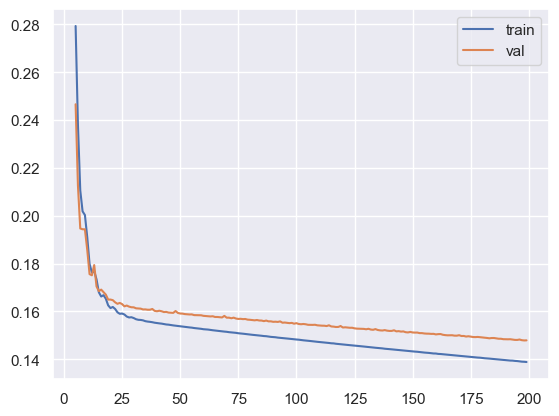

In [30]:
mode = load_model("./Model/MorphometricMNISTEmbedding1", compile=False)
histo = pd.read_csv("./Model/MorphometricMNISTEmbedding1/training_history.log")
plt.plot(histo["mae"][5:], label="train")
plt.plot(histo["val_mae"][5:], label="val")
plt.legend()
plt.show()

In [36]:
model = load_model("./Model/MorphometricMNISTEmbedding1", compile=False)
predicted = model.predict([x_test, y_test]).reshape(10000,)
df = pd.DataFrame()
df["pred"] = predicted
df["target"] = test_morpho.slant
m = (np.abs(df.pred-df.target)).sum()/len(df.pred)
print(f"MAE_TEST: {m}")
df

c:\Users\Gonzalo\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\initializers\initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


313/313 [==============================] - 1s 1ms/step
MAE_TEST: 0.8451104747083001


,pred,target
0,3.287047,4.066199
1,-9.201002,-9.962917
2,15.989086,16.638250
3,3.939229,4.146705
4,-7.458380,-7.378214
...,...,...
9995,-0.336797,-1.446727
9996,-4.413342,-4.309251
9997,10.405151,11.246739
9998,30.739149,30.389567


$\textit{Embedding Plot}$

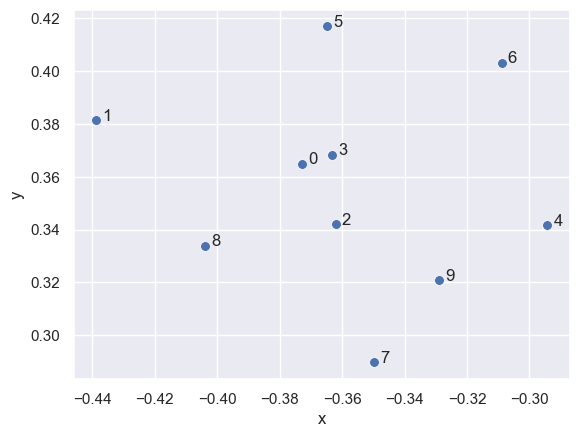

In [32]:
 from matplotlib import cm

layerName = 'Embe'
intermediate_layer = Model(inputs=model.get_layer(layerName).input,
                                    outputs=model.get_layer(layerName).output)


intermediate_output = intermediate_layer(labels)


x = intermediate_output[:, 0, 0]
y = intermediate_output[:, 0, 1]

data = pd.DataFrame()
data["x"] = x
data["y"] = y
data["label"] = labels

sns.scatterplot(
    x="x", y="y",
    s = 50,
    data=data,
)

for i in labels:
    plt.text(data['x'][i]+.002, data['y'][i], str(i))

Se entiende que la capa de embedding trata de buscar relaciones entre los datos de entrada. Se observa que los numeros 0, 2 y 3 se encuentran relativamente juntos, por lo que deberia existir cierta relacion entre ellos. Sin embargo, se compararon los histogramas de clases y las inclinaciones de cada numero y no se encontraron relaciones concluyentes.

## $\textit{Predict using image and height}$

In [33]:
BATCH_SIZE = 64
INIT_LR = 0.000005
MAX_LR = 0.001
steps_per_epoch = len(x_train) // BATCH_SIZE
callbackCLR = tfa.optimizers.CyclicalLearningRate(initial_learning_rate=INIT_LR,
    maximal_learning_rate=MAX_LR,
    scale_fn=lambda x: 1/(2.**(x-1)),
    step_size=2 * steps_per_epoch
)

loc = './Model/MorphometricMNIST_H/training_history.log'
callbackH = helper.callbackH(location=loc)

callbackROP = ReduceLROnPlateau(monitor="val_mae",
                      factor = 0.1,
                      verbose= 1,
                      pacience = 10,
                      max_lr = MAX_LR)

callbackES = EarlyStopping(monitor="val_mae", patience=20)
initializer = GlorotNormal()

measure = Sequential()
measure.add(Input((1,)))

img = Sequential()
img.add(Flatten(input_shape=(28,28)))
img.add(Dense(100, activation="sigmoid", kernel_initializer=initializer))
img.add(Dense(100, activation="sigmoid", kernel_initializer=initializer))

modelConcat = Concatenate()([img.output, measure.output])
modelConcat = Dense(1, activation="linear", kernel_initializer=initializer)(modelConcat)
model = Model(inputs=[img.input, measure.input], outputs=modelConcat)
model.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 flatten_11_input (InputLayer)  [(None, 28, 28)]     0           []                               
                                                                                                  
 flatten_11 (Flatten)           (None, 784)          0           ['flatten_11_input[0][0]']       
                                                                                                  
 dense_27 (Dense)               (None, 100)          78500       ['flatten_11[0][0]']             
                                                                                                  
 dense_28 (Dense)               (None, 100)          10100       ['dense_27[0][0]']               
                                                                                            

c:\Users\Gonzalo\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\initializers\initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [34]:
model.compile(loss = MeanAbsoluteError(), optimizer=Nadam(callbackCLR), metrics=["mae"])
history = model.fit(x=[x_train, var_x_train], y =y_train, validation_data=([x_val, var_x_val], y_val), callbacks=[callbackES, callbackROP, callbackH], batch_size = BATCH_SIZE, epochs=200)
model.save("./Model/MorphometricMNIST_H")

Epoch 1/200
782/782 [==============================] - 3s 3ms/step - loss: 8.6248 - mae: 8.6248 - val_loss: 3.0012 - val_mae: 3.0012 - lr: 5.0250e-04
Epoch 2/200
782/782 [==============================] - 2s 3ms/step - loss: 1.4417 - mae: 1.4417 - val_loss: 0.5418 - val_mae: 0.5418 - lr: 9.9936e-04
Epoch 3/200
782/782 [==============================] - 2s 3ms/step - loss: 0.4417 - mae: 0.4417 - val_loss: 0.3055 - val_mae: 0.3055 - lr: 5.0123e-04
Epoch 4/200
782/782 [==============================] - 2s 3ms/step - loss: 0.3055 - mae: 0.3055 - val_loss: 0.2609 - val_mae: 0.2609 - lr: 5.9555e-06
Epoch 5/200
782/782 [==============================] - 2s 3ms/step - loss: 0.2800 - mae: 0.2800 - val_loss: 0.2518 - val_mae: 0.2518 - lr: 2.5502e-04
Epoch 6/200
782/782 [==============================] - 2s 3ms/step - loss: 0.2622 - mae: 0.2622 - val_loss: 0.2799 - val_mae: 0.2799 - lr: 5.0091e-04
Epoch 7/200
782/782 [==============================] - 2s 3ms/step - loss: 0.2291 - mae: 0.2291 - va

INFO:tensorflow:Assets written to: ./Model/MorphometricMNIST_H\assets


INFO:tensorflow:Assets written to: ./Model/MorphometricMNIST_H\assets


c:\Users\Gonzalo\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\initializers\initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


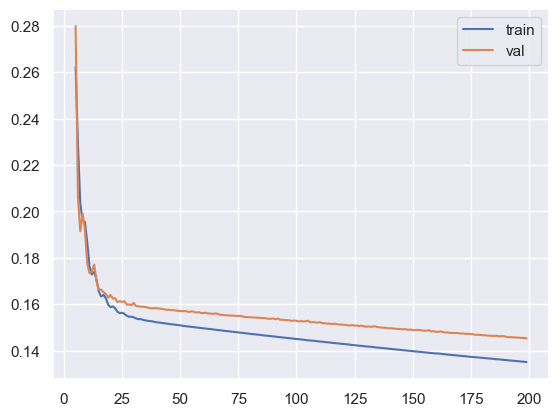

In [36]:
mode = load_model("./Model/MorphometricMNIST_H", compile=False)
histo = pd.read_csv("./Model/MorphometricMNIST_H/training_history.log")
plt.plot(histo["mae"][5:], label="train")
plt.plot(histo["val_mae"][5:], label="val")
plt.legend()
plt.show()

In [38]:
model = load_model("./Model/MorphometricMNIST_H", compile=False)
predicted = model.predict([x_test, var_x_test]).reshape(10000,)
df = pd.DataFrame()
df["pred"] = predicted
df["target"] = test_morpho.slant
m = (np.abs(df.pred-df.target)).sum()/len(df.pred)
print(f"MAE_TEST: {m}")
df

c:\Users\Gonzalo\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\initializers\initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


313/313 [==============================] - 0s 1ms/step
MAE_TEST: 0.8823866328257194


,pred,target
0,3.273163,4.066199
1,-9.029599,-9.962917
2,16.321812,16.638250
3,5.384920,4.146705
4,-8.939439,-7.378214
...,...,...
9995,-0.874209,-1.446727
9996,-3.540857,-4.309251
9997,13.741924,11.246739
9998,30.744848,30.389567


$\textit{MAE vs BATCHSIZE}$

In [79]:
model = load_model("./Model/MorphometricMNISTEmbedding1", compile=False)
model.load_weights("./Model/MorphometricMNISTEmbedding1/defaultWeights.h5")
INIT_LR = 0.000005
MAX_LR = 0.001
BATCH_SIZE = 32
mae_valResults = []

steps_per_epoch = len(x_train) // BATCH_SIZE
callbackCLR = tfa.optimizers.CyclicalLearningRate(initial_learning_rate=INIT_LR,
    maximal_learning_rate=MAX_LR,
    scale_fn=lambda x: 1/(2.**(x-1)),
    step_size=2 * steps_per_epoch
)

for i in range(6):
    model.compile(loss = MeanAbsoluteError(), optimizer=Nadam(callbackCLR), metrics=["mae"])
    history = model.fit(x=[x_train, x_emb], y =y_train, validation_data=([x_val, x_emb_val], y_val), callbacks=[callbackES, callbackROP], batch_size = BATCH_SIZE, epochs=200)
    mae_valResults.append(history.history["val_mae"][-1])
    print(history.history["val_mae"][-1])
    model.load_weights("./Model/MorphometricMNISTEmbedding1/defaultWeights.h5")
    BATCH_SIZE = int(BATCH_SIZE * 2)

c:\Users\Gonzalo\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\initializers\initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Epoch 1/200


1563/1563 [==============================] - 7s 4ms/step - loss: 7.5010 - mae: 7.5010 - val_loss: 1.8482 - val_mae: 1.8482 - lr: 5.0250e-04
Epoch 2/200
1563/1563 [==============================] - 6s 4ms/step - loss: 0.8848 - mae: 0.8848 - val_loss: 0.3696 - val_mae: 0.3696 - lr: 9.9968e-04
Epoch 3/200
1563/1563 [==============================] - 6s 4ms/step - loss: 0.3199 - mae: 0.3199 - val_loss: 0.2589 - val_mae: 0.2589 - lr: 5.0186e-04
Epoch 4/200
1563/1563 [==============================] - 6s 4ms/step - loss: 0.2262 - mae: 0.2262 - val_loss: 0.1946 - val_mae: 0.1946 - lr: 5.4778e-06
Epoch 5/200
1563/1563 [==============================] - 6s 4ms/step - loss: 0.2055 - mae: 0.2055 - val_loss: 0.2018 - val_mae: 0.2018 - lr: 2.5439e-04
Epoch 6/200
1563/1563 [==============================] - 6s 4ms/step - loss: 0.2062 - mae: 0.2062 - val_loss: 0.2027 - val_mae: 0.2027 - lr: 5.0170e-04
Epoch 7/200
1563/1563 [==============================] - 6s 4ms/step - loss: 0.1903 - mae: 0.1903 - 

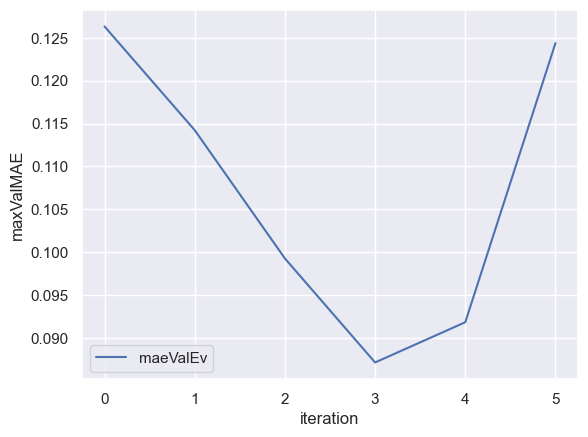

In [81]:
plt.plot(mae_valResults, label="maeValEv")
plt.xlabel("iteration")
plt.ylabel("maxValMAE")
plt.legend()
plt.show()

$\textit{MAE vs LR}$

In [85]:
INIT_LR = 0.00005
MAX_LR = 0.01
BATCH_SIZE = 256
mae_valResults = []

steps_per_epoch = len(x_train) // BATCH_SIZE
callbackCLR = tfa.optimizers.CyclicalLearningRate(initial_learning_rate=INIT_LR,
    maximal_learning_rate=MAX_LR,
    scale_fn=lambda x: 1/(2.**(x-1)),
    step_size=2 * steps_per_epoch
)

callbackROP = ReduceLROnPlateau(monitor="val_mae",
                      factor = 0.1,
                      verbose= 1,
                      pacience = 10,
                      max_lr = MAX_LR)

callbackES = EarlyStopping(monitor="val_mae", patience=20)
initializer = GlorotNormal()

emb = Sequential()
emb.add(Embedding(len(labels), 2, input_length=1, name="Embe"))
emb.add(Flatten())

img = Sequential()
img.add(Flatten(input_shape=(28,28)))
img.add(Dense(100, activation="elu", kernel_initializer=initializer))
img.add(Dense(100, activation="elu", kernel_initializer=initializer))

modelConcat = Concatenate()([img.output, emb.output])
modelConcat = Dense(1, activation="linear", kernel_initializer=initializer)(modelConcat)
model = Model(inputs=[img.input, emb.input], outputs=modelConcat)
model.summary()
model.save_weights("./Model/MorphometricMNISTEmbedding1/defaultWeights.h5")

for i in range(5):
    for j in range(5):
        model.compile(loss = MeanAbsoluteError(), optimizer=Nadam(callbackCLR), metrics=["mae"])
        history = model.fit(x=[x_train, x_emb], y =y_train, validation_data=([x_val, x_emb_val], y_val), callbacks=[callbackES, callbackROP], batch_size = BATCH_SIZE, epochs=200)
        mae_valResults.append(history.history["val_mae"][-1])
        model.load_weights("./Model/MorphometricMNISTEmbedding1/defaultWeights.h5")
        INIT_LR = INIT_LR/5
    MAX_LR = MAX_LR/5

Model: "model_24"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 flatten_41_input (InputLayer)  [(None, 28, 28)]     0           []                               
                                                                                                  
 flatten_41 (Flatten)           (None, 784)          0           ['flatten_41_input[0][0]']       
                                                                                                  
 Embe_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 dense_72 (Dense)               (None, 100)          78500       ['flatten_41[0][0]']             
                                                                                           

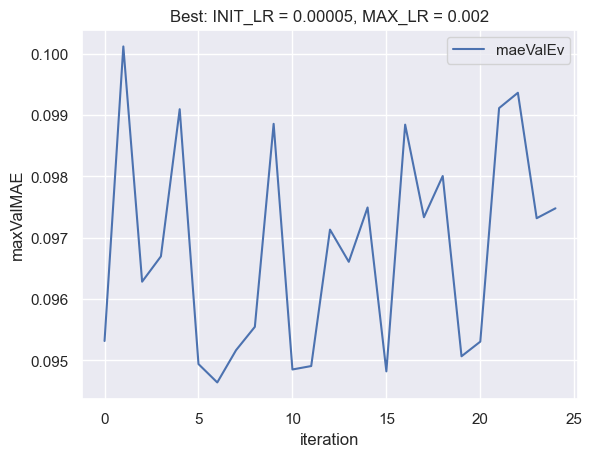

In [89]:
plt.plot(mae_valResults, label="maeValEv")
plt.xlabel("iteration")
plt.ylabel("maxValMAE")
plt.title(f"Best: INIT_LR = 0.00005, MAX_LR = 0.002")
plt.legend()
plt.show()

$\textit{MAE vs ACTIVATIONS}$

In [82]:
model = load_model("./Model/MorphometricMNISTEmbedding1", compile=False)
model.load_weights("./Model/MorphometricMNISTEmbedding1/defaultWeights.h5")
INIT_LR = 0.000005
MAX_LR = 0.001
BATCH_SIZE = 256
mae_valResults = []
activs = ["exponential", "relu", "elu", "sigmoid", "tanh", "selu"]

steps_per_epoch = len(x_train) // BATCH_SIZE
callbackCLR = tfa.optimizers.CyclicalLearningRate(initial_learning_rate=INIT_LR,
    maximal_learning_rate=MAX_LR,
    scale_fn=lambda x: 1/(2.**(x-1)),
    step_size=2 * steps_per_epoch
)

for act in activs:

    emb = Sequential()
    emb.add(Embedding(len(labels), 2, input_length=1, name="Embe"))
    emb.add(Flatten())

    img = Sequential()
    img.add(Flatten(input_shape=(28,28)))
    img.add(Dense(100, activation=act, kernel_initializer=initializer))
    img.add(Dense(100, activation=act, kernel_initializer=initializer))

    modelConcat = Concatenate()([img.output, emb.output])
    modelConcat = Dense(1, activation="linear", kernel_initializer=initializer)(modelConcat)
    model = Model(inputs=[img.input, emb.input], outputs=modelConcat)
    
    model.compile(loss = MeanAbsoluteError(), optimizer=Nadam(callbackCLR), metrics=["mae"])
    history = model.fit(x=[x_train, x_emb], y =y_train, validation_data=([x_val, x_emb_val], y_val), callbacks=[callbackES, callbackROP], batch_size = BATCH_SIZE, epochs=200)
    mae_valResults.append(history.history["val_mae"][-1])
    model.load_weights("./Model/MorphometricMNISTEmbedding1/defaultWeights.h5")

c:\Users\Gonzalo\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\initializers\initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Epoch 1/200


c:\Users\Gonzalo\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\initializers\initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


196/196 [==============================] - 2s 6ms/step - loss: 5.4281 - mae: 5.4281 - val_loss: 1.6520 - val_mae: 1.6520 - lr: 5.0250e-04
Epoch 2/200
196/196 [==============================] - 1s 6ms/step - loss: 1.3407 - mae: 1.3407 - val_loss: 0.8487 - val_mae: 0.8487 - lr: 9.9745e-04
Epoch 3/200
196/196 [==============================] - 1s 5ms/step - loss: 0.8250 - mae: 0.8250 - val_loss: 0.6185 - val_mae: 0.6185 - lr: 4.9740e-04
Epoch 4/200
196/196 [==============================] - 1s 5ms/step - loss: 0.5514 - mae: 0.5514 - val_loss: 0.5261 - val_mae: 0.5261 - lr: 8.8269e-06
Epoch 5/200
196/196 [==============================] - 1s 5ms/step - loss: 0.5023 - mae: 0.5023 - val_loss: 0.5208 - val_mae: 0.5208 - lr: 2.5885e-04
Epoch 6/200
196/196 [==============================] - 1s 6ms/step - loss: 0.5682 - mae: 0.5682 - val_loss: 0.9049 - val_mae: 0.9049 - lr: 4.9612e-04
Epoch 7/200
196/196 [==============================] - 1s 6ms/step - loss: 0.4729 - mae: 0.4729 - val_loss: 0.42

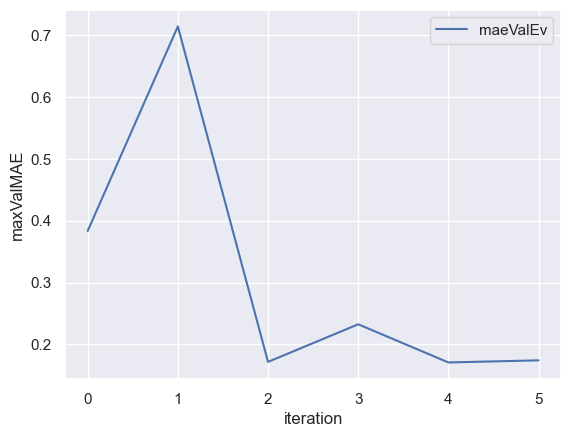

In [83]:
plt.plot(mae_valResults, label="maeValEv")
plt.xlabel("iteration")
plt.ylabel("maxValMAE")
plt.legend()
plt.show()

$\textit{The best model}$

In [39]:
BATCH_SIZE = 64
INIT_LR = 0.00005
MAX_LR = 0.002
steps_per_epoch = len(x_train) // BATCH_SIZE
callbackCLR = tfa.optimizers.CyclicalLearningRate(initial_learning_rate=INIT_LR,
    maximal_learning_rate=MAX_LR,
    scale_fn=lambda x: 1/(2.**(x-1)),
    step_size=2 * steps_per_epoch
)

callbackROP = ReduceLROnPlateau(monitor="val_mae",
                      factor = 0.1,
                      verbose= 1,
                      pacience = 10,
                      max_lr = MAX_LR)

callbackES = EarlyStopping(monitor="val_mae", patience=20)
initializer = GlorotNormal()

emb = Sequential()
emb.add(Embedding(len(labels), 2, input_length=1, name="Embe"))
emb.add(Flatten())

img = Sequential()
img.add(Flatten(input_shape=(28,28)))
img.add(Dense(100, activation="elu", kernel_initializer=initializer))
img.add(Dense(100, activation="elu", kernel_initializer=initializer))

modelConcat = Concatenate()([img.output, emb.output])
modelConcat = Dense(1, activation="linear", kernel_initializer=initializer)(modelConcat)
model = Model(inputs=[img.input, emb.input], outputs=modelConcat)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 flatten_7_input (InputLayer)   [(None, 28, 28)]     0           []                               
                                                                                                  
 flatten_7 (Flatten)            (None, 784)          0           ['flatten_7_input[0][0]']        
                                                                                                  
 Embe_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 dense_9 (Dense)                (None, 100)          78500       ['flatten_7[0][0]']              
                                                                                            

c:\Users\Gonzalo\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\initializers\initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [40]:
model.compile(loss = MeanAbsoluteError(), optimizer=Nadam(callbackCLR), metrics=["mae"])
history = model.fit(x=[x_train, x_emb], y =y_train, validation_data=([x_val, x_emb_val], y_val), callbacks=[callbackES, callbackROP], batch_size = BATCH_SIZE, epochs=200)
model.save("./Model/MorphometricMNIST_E")

Epoch 1/200
782/782 [==============================] - 4s 3ms/step - loss: 2.9543 - mae: 2.9543 - val_loss: 0.7605 - val_mae: 0.7605 - lr: 0.0010
Epoch 2/200
782/782 [==============================] - 2s 3ms/step - loss: 0.4694 - mae: 0.4694 - val_loss: 0.5929 - val_mae: 0.5929 - lr: 0.0020
Epoch 3/200
782/782 [==============================] - 2s 3ms/step - loss: 0.3122 - mae: 0.3122 - val_loss: 0.2281 - val_mae: 0.2281 - lr: 0.0010
Epoch 4/200
782/782 [==============================] - 2s 3ms/step - loss: 0.1976 - mae: 0.1976 - val_loss: 0.1724 - val_mae: 0.1724 - lr: 5.1873e-05
Epoch 5/200
782/782 [==============================] - 2s 3ms/step - loss: 0.1779 - mae: 0.1779 - val_loss: 0.2109 - val_mae: 0.2109 - lr: 5.4000e-04
Epoch 6/200
782/782 [==============================] - 2s 3ms/step - loss: 0.2250 - mae: 0.2250 - val_loss: 0.2325 - val_mae: 0.2325 - lr: 0.0010
Epoch 7/200
782/782 [==============================] - 2s 3ms/step - loss: 0.2054 - mae: 0.2054 - val_loss: 0.2152 -

INFO:tensorflow:Assets written to: ./Model/MorphometricMNIST_E\assets


INFO:tensorflow:Assets written to: ./Model/MorphometricMNIST_E\assets


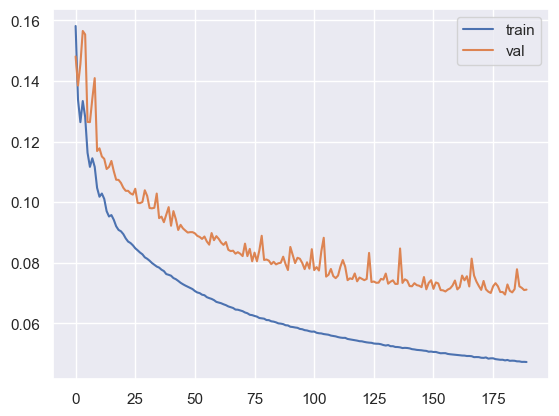

In [41]:
plt.plot(history.history["mae"][10:], label="train")
plt.plot(history.history["val_mae"][10:], label="val")
plt.legend()
plt.show()

In [44]:
model = load_model("./Model/MorphometricMNIST_E", compile=False)
predicted = model.predict([x_test, y_test]).reshape(10000,)
df = pd.DataFrame()
df["pred"] = predicted
df["target"] = test_morpho.slant
m = (np.abs(df.pred-df.target)).sum()/len(df.pred)
print(f"MAE_TEST: {m}")
df

c:\Users\Gonzalo\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\initializers\initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


313/313 [==============================] - 1s 1ms/step
MAE_TEST: 409.5696667779149


,pred,target
0,131.111420,4.066199
1,-658.384827,-9.962917
2,225.256531,16.638250
3,132.698730,4.146705
4,-192.995056,-7.378214
...,...,...
9995,-182.515945,-1.446727
9996,-315.125153,-4.309251
9997,339.668274,11.246739
9998,796.108887,30.389567
